# This notebook will contain the model training process, evaluation, and hyperparameter tuning:

- Model selection using H2O AutoML

- Splitting data into train/test sets

- Model training, evaluation, and cross-validation

- Hyperparameter tuning

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import h2o
from h2o.automl import H2OAutoML

### Input 02-notebook file

In [ ]:
path = '../data/processed/heart_2022_processed_02.csv'

In [3]:
# read data
df = pd.read_csv(path ,sep=',',encoding='utf-8')
df.sample(5)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,SleepHours_Category,BMI_WeightInKilograms_interaction,BMI_HeightInMeters_interaction,WeightInKilograms_HeightInMeters_interaction,BMI^2_poly,BMI_WeightInKilograms_poly,BMI_HeightInMeters_poly,WeightInKilograms^2_poly,WeightInKilograms_HeightInMeters_poly,HeightInMeters^2_poly
386579,WA,0,3,0.090987,-0.515488,3,1,0.656772,0,0,...,0,-0.503967,-0.487860,-0.705816,-0.350428,-0.503967,-0.487860,-0.607399,-0.705816,-0.714037
205223,MN,0,3,0.090987,1.890823,3,1,0.656772,0,0,...,0,-0.201537,-0.284778,-0.220890,-0.220646,-0.201537,-0.284778,-0.192955,-0.220890,-0.528630
246367,NJ,1,4,-0.491530,-0.515488,3,1,1.329001,1,0,...,2,-0.201537,-0.157846,-0.119801,-0.220646,-0.201537,-0.157846,-0.192955,-0.119801,-0.055220
310627,PA,0,1,3.003572,-0.274857,3,0,2.001231,1,0,...,2,0.133826,0.268698,-0.475854,0.591965,0.133826,0.268698,-0.247988,-0.475854,-1.433055
174973,MA,0,0,3.003572,1.168930,3,0,-1.359916,2,0,...,1,2.162529,2.131692,1.315695,2.449337,2.162529,2.131692,1.674286,1.315695,-0.528630


In [4]:
output_path = '../data/cleaned/dtype.csv'
df.dtypes.to_csv(output_path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442067 entries, 0 to 442066
Data columns (total 51 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   State                                         442067 non-null  object 
 1   Sex                                           442067 non-null  int64  
 2   GeneralHealth                                 442067 non-null  int64  
 3   PhysicalHealthDays                            442067 non-null  float64
 4   MentalHealthDays                              442067 non-null  float64
 5   LastCheckupTime                               442067 non-null  int64  
 6   PhysicalActivities                            442067 non-null  int64  
 7   SleepHours                                    442067 non-null  float64
 8   RemovedTeeth                                  442067 non-null  int64  
 9   HadHeartAttack                                44

### H2O AutoML to Select and Train the Best Mode

#### Splitting data into train/test sets


In [6]:
# Start H2O cluster
h2o.init()
# Convert data into H2O frame (required by H2O)
h2o_df = h2o.H2OFrame(df)
h2o_df['HadHeartAttack'] = h2o_df['HadHeartAttack'].asfactor()

# Specify the target column
target = 'HadHeartAttack'

# Define the feature columns
features = [col for col in df.columns if col != target]

# Split the dataset into training and testing sets
train, test = h2o_df.split_frame(ratios=[.8], seed=42)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.27" 2025-04-15; OpenJDK Runtime Environment Homebrew (build 11.0.27+0); OpenJDK 64-Bit Server VM Homebrew (build 11.0.27+0, mixed mode)
  Starting server from /Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/tmpythu7f9_
  JVM stdout: /var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/tmpythu7f9_/h2o_chiushihchan_started_from_python.out
  JVM stderr: /var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/tmpythu7f9_/h2o_chiushihchan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Taipei
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 25 days
H2O_cluster_name:,H2O_from_python_chiushihchan_bdaqeq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


#### Obective function: F1

In [7]:
# Train the AutoML model
aml = H2OAutoML(max_runtime_secs = 600, seed=42, sort_metric="f1")
aml.train(x=features, y=target, training_frame=train)

# Get the leaderboard of models
lb = aml.leaderboard
print(lb)

# Get the best model and evaluate it on the test set
best_model = aml.leader
predictions = best_model.predict(test)

# Evaluate model performance on the test set
performance = best_model.model_performance(test)
f1 = performance.F1()

# Print Recall score for the best model
print(f"Best Model's F1 Score: {f1}")

AutoML progress: |
21:10:20.447: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                    f1       auc    logloss     aucpr    mean_per_class_error      rmse        mse
DeepLearning_grid_1_AutoML_1_20250522_211019_model_3  0.346217  0.759035   0.293678  0.25672                 0.339276  0.225344  0.05078
GBM_grid_1_AutoML_1_20250522_211019_model_3           0.382536  0.844961   0.179001  0.294809                0.293273  0.216966  0.0470742
GBM_grid_1_AutoML_1_20250522_211019_model_48          0.389982  0.831767   0.182141  0.314284                0.30732   0.21717   0.0471626
GBM_grid_1_AutoML_1_20250522_211019_model_24          0.426654  0.852664   0.180042  0.344134                0.298099  0.213595  0.0456228
GBM_grid_1_AutoML_1_20250522_211019_model_34          0.427841  0.870921   0.16325   0.343113                0.284016  0.210515  0.0443167
GBM_grid_1

In [8]:
# Get feature importance for the best model
feature_importance = best_model.varimp()

# Convert feature importance to pandas DataFrame
feature_importance_df = pd.DataFrame(feature_importance)
feature_importance_df 

,0,1,2,3
0,HighRiskLastYear,1.000000,1.000000,0.018375
1,DifficultyDressingBathing,0.880050,0.880050,0.016171
2,"RaceEthnicityCategory.White only, Non-Hispanic",0.819237,0.819237,0.015054
3,LastCheckupTime,0.786928,0.786928,0.014460
4,HeightInMeters,0.782520,0.782520,0.014379
...,...,...,...,...
104,SmokerStatus,0.349518,0.349518,0.006422
105,SleepHours_Category,0.347068,0.347068,0.006377
106,HadDiabetes,0.303454,0.303454,0.005576
107,State.missing(NA),0.000000,0.000000,0.000000


                                           variable  raw_importance  \
0                                  HighRiskLastYear        1.000000   
1                         DifficultyDressingBathing        0.880050   
2    RaceEthnicityCategory.White only, Non-Hispanic        0.819237   
3                                   LastCheckupTime        0.786928   
4                                    HeightInMeters        0.782520   
..                                              ...             ...   
104                                    SmokerStatus        0.349518   
105                             SleepHours_Category        0.347068   
106                                     HadDiabetes        0.303454   
107                               State.missing(NA)        0.000000   
108               RaceEthnicityCategory.missing(NA)        0.000000   

     scaled_importance  relative_importance  
0             1.000000             0.018375  
1             0.880050             0.016171  
2        

/var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/ipykernel_81421/387455214.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_30_features['variable'], x=top_30_features['scaled_importance'], palette='Set2')


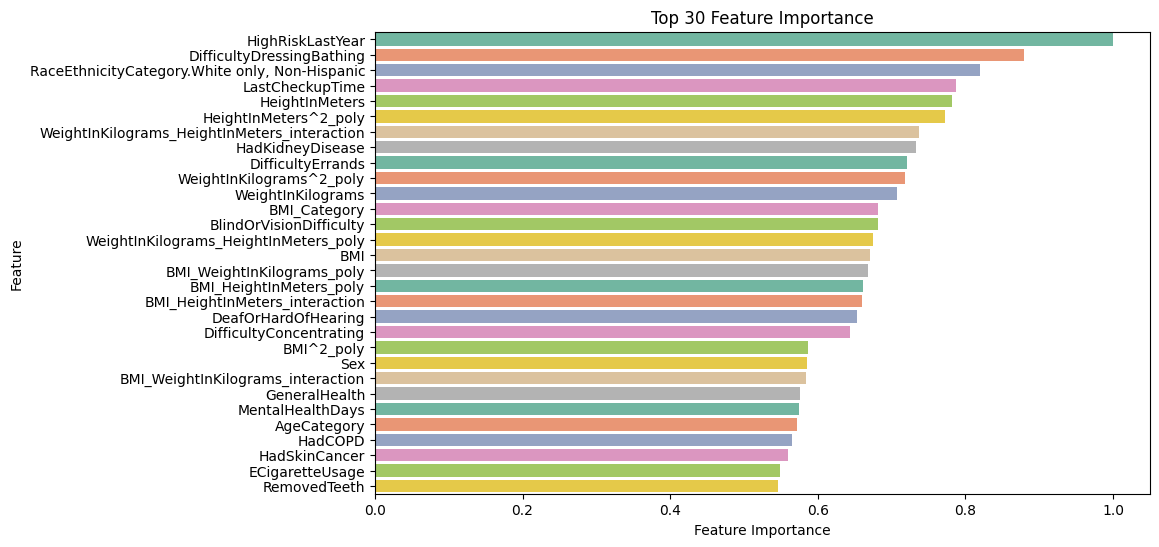

In [9]:
# Convert feature importance into a pandas DataFrame
feature_importance_df = pd.DataFrame(feature_importance, columns=['variable', 'raw_importance', 'scaled_importance', 'relative_importance'])

# Sort the features by scaled importance in descending order
feature_importance_df_sorted = feature_importance_df.sort_values(by="scaled_importance", ascending=False)

# Print the sorted feature importance
print(feature_importance_df_sorted)

# Plot the top 30 most important features
top_30_features = feature_importance_df_sorted.head(30)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(y=top_30_features['variable'], x=top_30_features['scaled_importance'], palette='Set2')

# Add labels and title
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 30 Feature Importance')

# Show the plot
plt.show()


                                           variable  raw_importance  \
108               RaceEthnicityCategory.missing(NA)        0.000000   
107                               State.missing(NA)        0.000000   
106                                     HadDiabetes        0.303454   
105                             SleepHours_Category        0.347068   
104                                    SmokerStatus        0.349518   
..                                              ...             ...   
4                                    HeightInMeters        0.782520   
3                                   LastCheckupTime        0.786928   
2    RaceEthnicityCategory.White only, Non-Hispanic        0.819237   
1                         DifficultyDressingBathing        0.880050   
0                                  HighRiskLastYear        1.000000   

     scaled_importance  relative_importance  
108           0.000000             0.000000  
107           0.000000             0.000000  
106      

/var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/ipykernel_81421/2743676325.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_30_features['variable'], x=top_30_features['scaled_importance'], palette='Set2')


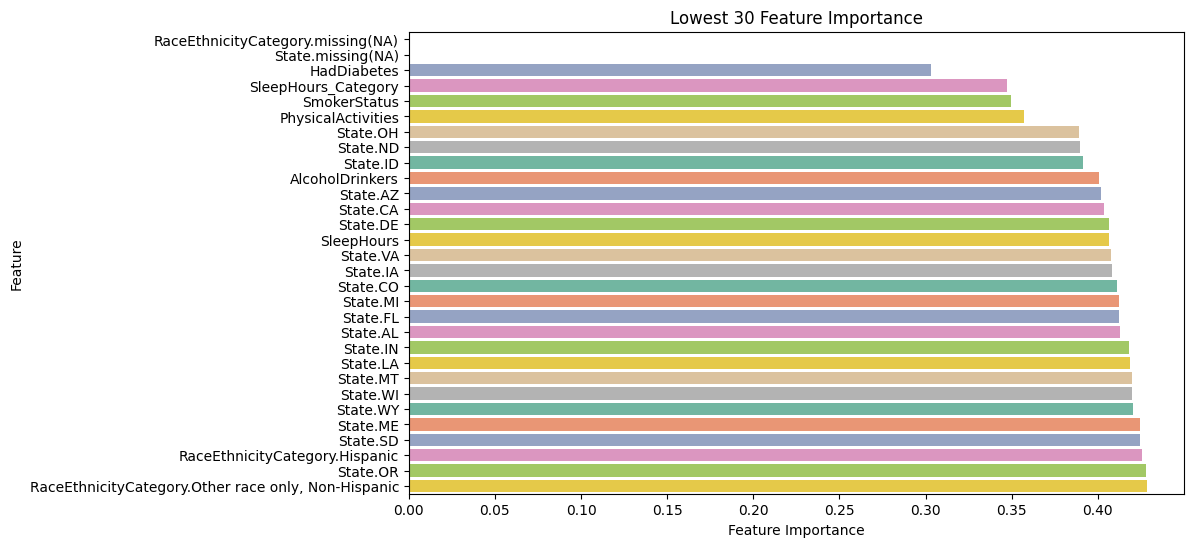

In [10]:
# Convert feature importance into a pandas DataFrame
feature_importance_df = pd.DataFrame(feature_importance, columns=['variable', 'raw_importance', 'scaled_importance', 'relative_importance'])

# Sort the features by scaled importance in descending order
feature_importance_df_sorted = feature_importance_df.sort_values(by="scaled_importance", ascending=True)

# Print the sorted feature importance
print(feature_importance_df_sorted)

# Plot the top 30 most important features
top_30_features = feature_importance_df_sorted.head(30)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(y=top_30_features['variable'], x=top_30_features['scaled_importance'], palette='Set2')

# Add labels and title
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Lowest 30 Feature Importance')

# Show the plot
plt.show()

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


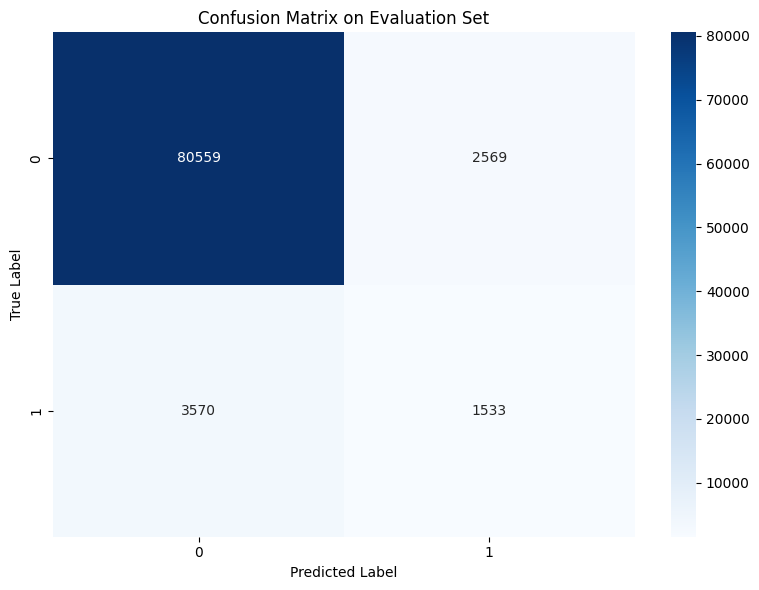

In [11]:
# Get the predictions from the best model (we assume the best model is already trained)
predictions = best_model.predict(test)

# Convert predictions to a pandas DataFrame for easier handling
predictions = predictions.as_data_frame()['predict']

# Get the true labels (actual values from the test set)
eval_labels = test['HadHeartAttack'].as_data_frame()['HadHeartAttack']

# Compute the confusion matrix
cm = confusion_matrix(eval_labels, predictions)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(eval_labels),
            yticklabels=np.unique(eval_labels))

# Adding labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Evaluation Set")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

#### Obective function: Recall

In [12]:
# Train the AutoML model
aml = H2OAutoML(max_runtime_secs = 600, seed=42, sort_metric="recall")
aml.train(x=features, y=target, training_frame=train)

# Get the leaderboard of models
lb = aml.leaderboard
print(lb)

# Get the best model and evaluate it on the test set
best_model = aml.leader
predictions = best_model.predict(test)

# Evaluate model performance on the test set
performance = best_model.model_performance(test)
recall = performance.recall()

# Print Recall score for the best model
print(f"Best Model's Recall Score: {recall}")

AutoML progress: |
21:20:27.517: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                recall       auc    logloss     aucpr    mean_per_class_error      rmse        mse
GBM_grid_1_AutoML_2_20250522_212027_model_6                  1  0.885595   0.151297  0.400139                0.263091  0.20323   0.0413024
DRF_1_AutoML_2_20250522_212027                               1  0.870225   0.158473  0.386538                0.27254   0.204089  0.0416523
GBM_5_AutoML_2_20250522_212027                               1  0.885777   0.150635  0.401532                0.268194  0.202618  0.0410539
GBM_grid_1_AutoML_2_20250522_212027_model_40                 1  0.884118   0.151821  0.401402                0.263342  0.203475  0.0414019
GBM_grid_1_AutoML_2_20250522_212027_model_34                 1  0.870921   0.16325   0.343113                0.284016  0.210515  0.0443167
DeepLear

In [13]:
# Get feature importance for the best model
feature_importance = best_model.varimp()

# Convert feature importance to pandas DataFrame
feature_importance_df = pd.DataFrame(feature_importance)

feature_importance_df 

,0,1,2,3
0,HadAngina,9834.622070,1.000000,0.544912
1,State,2190.675293,0.222751,0.121380
2,HadStroke,1047.497681,0.106511,0.058039
3,AgeCategory,554.766541,0.056410,0.030738
4,GeneralHealth,460.410767,0.046815,0.025510
5,RemovedTeeth,349.477081,0.035535,0.019364
6,ChestScan,281.029449,0.028576,0.015571
7,HadDiabetes,260.166718,0.026454,0.014415
8,Sex,259.731049,0.026410,0.014391
9,PhysicalHealthDays,239.021759,0.024304,0.013244


                                        variable  raw_importance  \
0                                      HadAngina     9834.622070   
1                                          State     2190.675293   
2                                      HadStroke     1047.497681   
3                                    AgeCategory      554.766541   
4                                  GeneralHealth      460.410767   
5                                   RemovedTeeth      349.477081   
6                                      ChestScan      281.029449   
7                                    HadDiabetes      260.166718   
8                                            Sex      259.731049   
9                             PhysicalHealthDays      239.021759   
10                                HeightInMeters      167.129761   
11                                  SmokerStatus      162.662796   
12                         HeightInMeters^2_poly      149.560623   
13                              MentalHealthDays

/var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/ipykernel_81421/387455214.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_30_features['variable'], x=top_30_features['scaled_importance'], palette='Set2')


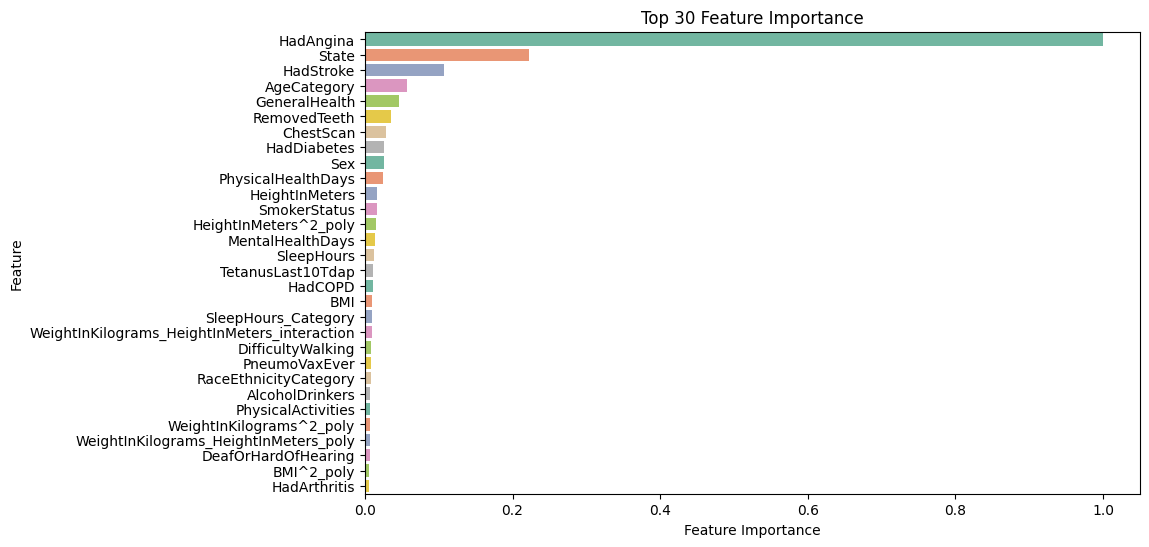

In [14]:
# Convert feature importance into a pandas DataFrame
feature_importance_df = pd.DataFrame(feature_importance, columns=['variable', 'raw_importance', 'scaled_importance', 'relative_importance'])

# Sort the features by scaled importance in descending order
feature_importance_df_sorted = feature_importance_df.sort_values(by="scaled_importance", ascending=False)

# Print the sorted feature importance
print(feature_importance_df_sorted)

# Plot the top 30 most important features
top_30_features = feature_importance_df_sorted.head(30)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(y=top_30_features['variable'], x=top_30_features['scaled_importance'], palette='Set2')

# Add labels and title
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 30 Feature Importance')

# Show the plot
plt.show()


                                        variable  raw_importance  \
49                              HighRiskLastYear        0.462887   
48                               LastCheckupTime       11.819421   
47                               ECigaretteUsage       19.200161   
46                                 HadSkinCancer       19.314274   
45                       BlindOrVisionDifficulty       23.356260   
44                                     HadAsthma       26.401278   
43                       DifficultyConcentrating       28.118984   
42                     DifficultyDressingBathing       29.302782   
41                                    HIVTesting       31.581642   
40                         HadDepressiveDisorder       31.822861   
39                                  BMI_Category       32.295090   
38                    BMI_WeightInKilograms_poly       32.882824   
37                             DifficultyErrands       33.553238   
36                                      CovidPos

/var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/ipykernel_81421/2743676325.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_30_features['variable'], x=top_30_features['scaled_importance'], palette='Set2')


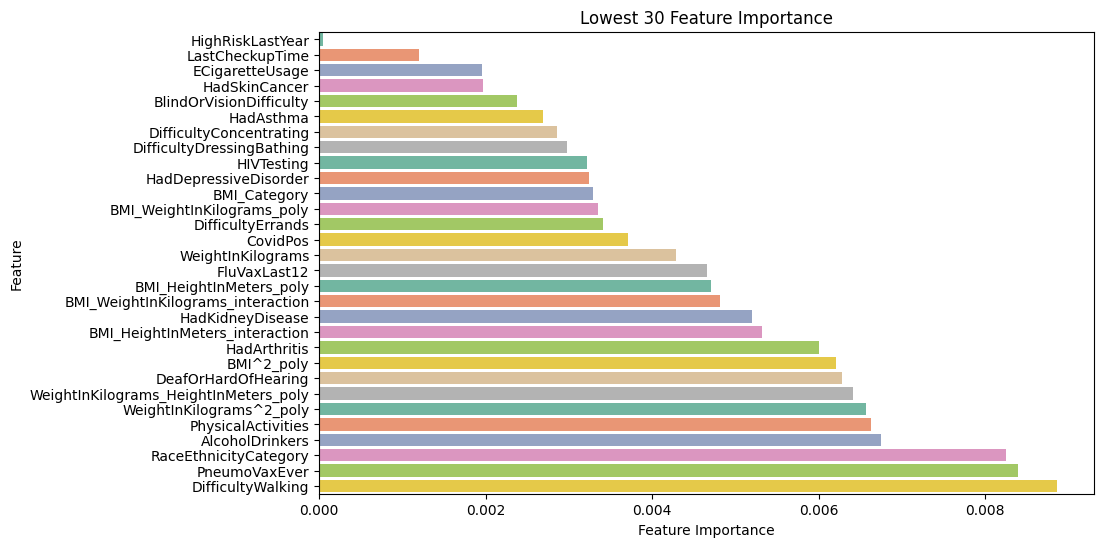

In [15]:
# Convert feature importance into a pandas DataFrame
feature_importance_df = pd.DataFrame(feature_importance, columns=['variable', 'raw_importance', 'scaled_importance', 'relative_importance'])

# Sort the features by scaled importance in descending order
feature_importance_df_sorted = feature_importance_df.sort_values(by="scaled_importance", ascending=True)

# Print the sorted feature importance
print(feature_importance_df_sorted)

# Plot the top 30 most important features
top_30_features = feature_importance_df_sorted.head(30)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(y=top_30_features['variable'], x=top_30_features['scaled_importance'], palette='Set2')

# Add labels and title
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Lowest 30 Feature Importance')

# Show the plot
plt.show()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


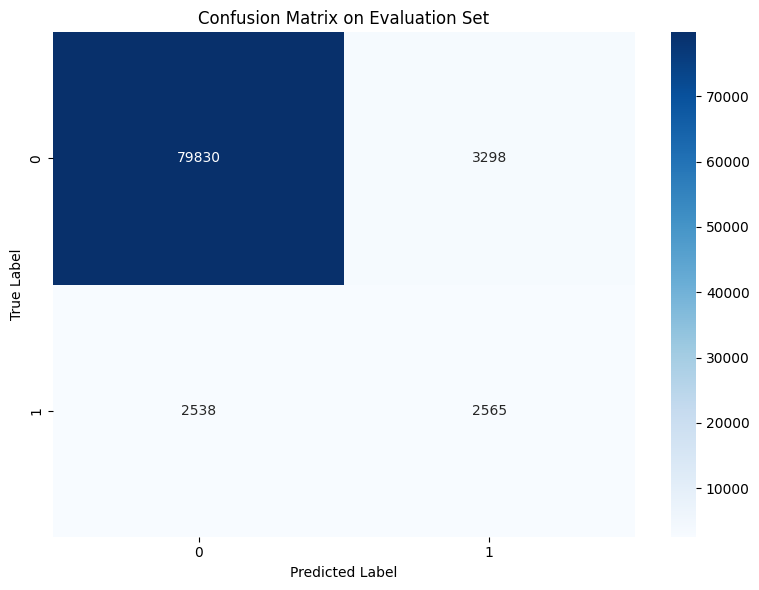

In [16]:
# Get the predictions from the best model (we assume the best model is already trained)
predictions = best_model.predict(test)

# Convert predictions to a pandas DataFrame for easier handling
predictions = predictions.as_data_frame()['predict']

# Get the true labels (actual values from the test set)
eval_labels = test['HadHeartAttack'].as_data_frame()['HadHeartAttack']

# Compute the confusion matrix
cm = confusion_matrix(eval_labels, predictions)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(eval_labels),
            yticklabels=np.unique(eval_labels))

# Adding labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Evaluation Set")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### ROC curve

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


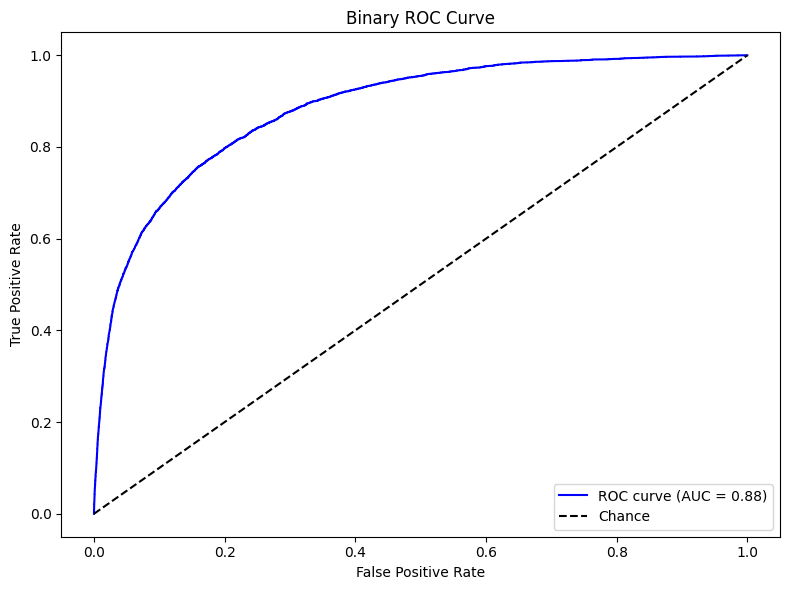

In [20]:
# Get predicted probabilities for the positive class (assumes binary classification)
probs = best_model.predict(test).as_data_frame()['p1']  # 'p1' is H2O's probability of class 1

# True labels
eval_labels = test['HadHeartAttack'].as_data_frame()['HadHeartAttack']

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(eval_labels, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
palette = sns.color_palette("Set2")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Binary ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### SHAP

In [21]:
# Get SHAP values for the test set
contributions = best_model.predict_contributions(test)

# Convert to DataFrame
shap_df = contributions.as_data_frame()

# Remove the last column ('BiasTerm')
shap_df = shap_df.drop(columns=["BiasTerm"])

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [37]:
import shap

# Convert to NumPy for SHAP
shap_values = shap_df.values
feature_names = shap_df.columns

# Initialize SHAP explainer (Dummy — needed for plotting only)
explainer = shap.Explainer(lambda x: shap_values, feature_names)

# Create dummy "test" data matrix for visualization
X_sample = test[:, feature_names].as_data_frame()

# Plot SHAP summary (like beeswarm)
shap.summary_plot(shap_values, X_sample, feature_names=feature_names)

ModuleNotFoundError: No module named 'shap'

In [ ]:
# Visualize the first prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_sample.iloc[0])
